In [ ]:
# Import necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Load the cleaned dataset
df = pd.read_csv('cleaned_dataset.csv')
df.head()

,tweet,product,emotion,cleaned_tweet,tokenized_tweet,removed_stop_tweet,pos_tagged,lemmatized_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,wesley83 i have a 3g iphone after 3 hrs tweeti...,"['wesley83', 'i', 'have', 'a', '3g', 'iphone',...","['wesley83', '3g', 'iphone', '3', 'hrs', 'twee...","[('wesley83', 'NN'), ('3g', 'CD'), ('iphone', ...",wesley83 3g iphone 3 hr tweet rise_austin dead...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,jessedee know about fludapp awesome ipadiphone...,"['jessedee', 'know', 'about', 'fludapp', 'awes...","['jessedee', 'know', 'fludapp', 'awesome', 'ip...","[('jessedee', 'NN'), ('know', 'VBP'), ('fludap...",jessedee know fludapp awesome ipadiphone app y...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,swonderlin can not wait for ipad 2 also they s...,"['swonderlin', 'can', 'not', 'wait', 'for', 'i...","['swonderlin', 'wait', 'ipad', '2', 'also', 's...","[('swonderlin', 'NN'), ('wait', 'NN'), ('ipad'...",swonderlin wait ipad 2 also sale sxsw
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,sxsw i hope this years festival isnt as crashy...,"['sxsw', 'i', 'hope', 'this', 'years', 'festiv...","['sxsw', 'hope', 'years', 'festival', 'isnt', ...","[('sxsw', 'JJ'), ('hope', 'NN'), ('years', 'NN...",sxsw hope year festival isnt crashy year iphon...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,sxtxstate great stuff on fri sxsw marissa maye...,"['sxtxstate', 'great', 'stuff', 'on', 'fri', '...","['sxtxstate', 'great', 'stuff', 'fri', 'sxsw',...","[('sxtxstate', 'NN'), ('great', 'JJ'), ('stuff...",sxtxstate great stuff fri sxsw marissa mayer g...


In [ ]:
df['emotion'].value_counts()

emotion
No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64

### Explanatory Data Analysis

#### A barplot

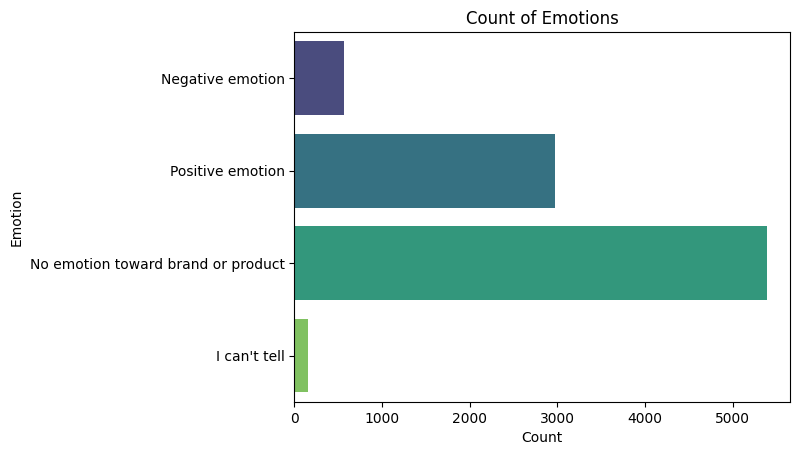

In [ ]:
# Visualizing the emotion column
sns.countplot(y='emotion', data=df, palette='viridis')
plt.title('Count of Emotions')
plt.xlabel('Count')
plt.ylabel('Emotion')
plt.show()

- The most frequently occurring emotion is `No emotion toward brand or product`, with a count of .
Mention Less Frequent Emotions: "Other emotions, such as `4568` and `I can't tell`, are less common.

- There is a noticeable disparity between the counts of No emotion toward brand or product (4568) and the other emotions, with Positive emotion being the next most frequent at 2527, and Negative emotion at 501.


- The high frequency of No emotion toward brand or product might be attributed to users sharing informational or factual content about the products rather than personal opinions or emotional responses.

#### A histogram

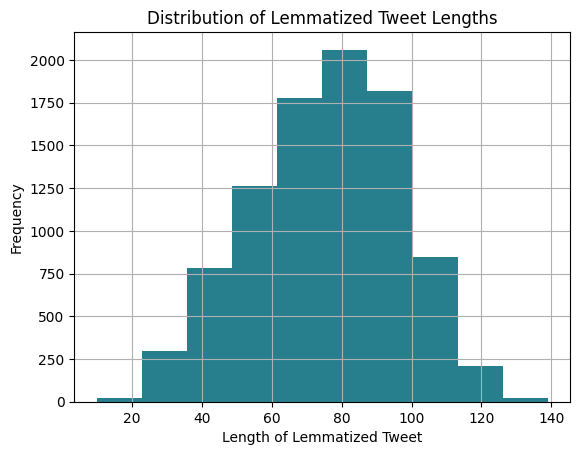

In [ ]:
# Plotting a histogram to visualize the `lemmatized tweet` column
colors = sns.color_palette("viridis")  # Get the viridis palette
df['lemmatized_tweet'].str.len().hist(color=colors[2])  # Use the second color (green)
plt.xlabel('Length of Lemmatized Tweet')
plt.ylabel('Frequency')
plt.title('Distribution of Lemmatized Tweet Lengths')
plt.show()

The histogram shows that news `lemmatized tweet` range from 10 to 140 characters  

**A histogram to visualize the average length of words in google and apple products tweets**

The overall average word length is: 5.222132620167922


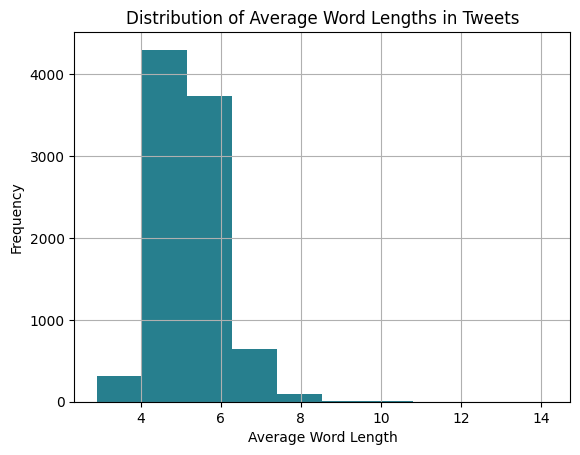

In [ ]:
# A histogram to visualize the average length of words in google and apple products tweets
"""
calculates the average word length for each tweet, and then creates a
histogram to display the distribution of these average word lengths.
"""

# Handle potential float values in 'lemmatized_tweet' column
df['lemmatized_tweet'] = df['lemmatized_tweet'].astype(str)

# Calculate average word lengths and plot histogram with viridis palette
colors = sns.color_palette("viridis")
df['lemmatized_tweet'].str.split().\
   apply(lambda x : [len(i) for i in x]).\
   map(lambda x: np.mean(x)).hist(color=colors[2]); # Use the second color in the viridis palette

# calculating average word lengths

average_word_lengths = df['lemmatized_tweet'].str.split().\
   apply(lambda x : [len(i) for i in x]).\
   map(lambda x: np.mean(x))

overall_average = average_word_lengths.mean()

print("The overall average word length is:", overall_average)

plt.xlabel('Average Word Length')
plt.ylabel('Frequency')
plt.title('Distribution of Average Word Lengths in Tweets')
plt.show()

The histogram shows that the average word length in these tweets is around 5 words, with most tweets falling within the range of 4-5.   

**Most frequent Bargrams used in the dataset**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

Text(0.5, 1.0, 'Top 5 Most Frequent Bigrams')

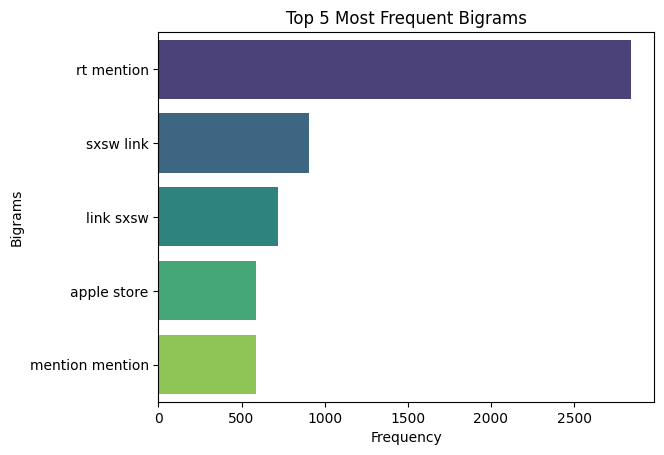

In [ ]:
top_n_bigrams=get_top_ngram(df['lemmatized_tweet'],2)[:5]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x, palette='viridis')
plt.xlabel('Frequency')  # Label for the x-axis
plt.ylabel('Bigrams')   # Label for the y-axis
plt.title('Top 5 Most Frequent Bigrams') #Title

We can observe that the bigrams such as `rt mention` is mostly related to  dominate the news headlines.The presence of bigrams such as "rt mention" dominating the dataset suggests that many tweets are retweets or mentions, which are typically used to highlight trending topics, news, and user opinions. This can imply that discussions about Apple and Google products are significantly influenced by social sharing and user interactions on the platform

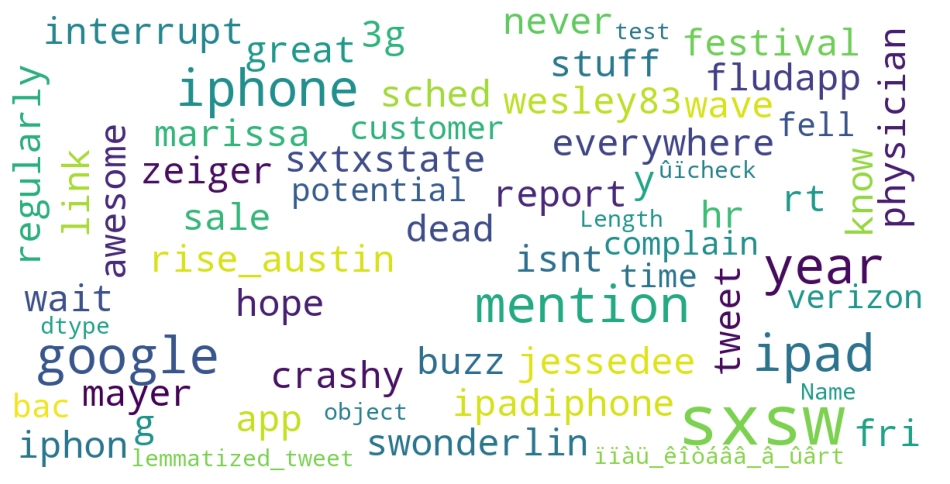

In [ ]:
from nltk import corpus
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)

    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

# show_wordcloud(corpus)
show_wordcloud(df['lemmatized_tweet'])

The large words in the word cloud provide a snapshot of the key topics and sentiments in our dataset. By focusing on these prominent terms, we can gain insights into user opinions, event influences, and brand mentions, which are crucial for the analysis of sentiment towards Apple and Google products.

In [ ]:
df['word_length'] = df['lemmatized_tweet'].str.split().apply(lambda x: [len(i) for i in x])
df

,tweet,product,emotion,cleaned_tweet,tokenized_tweet,removed_stop_tweet,pos_tagged,lemmatized_tweet,num_exclamation,num_question,word_length
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,wesley83 3g iphone 3 hr tweet rise_austin dead...,"['wesley83', 'i', 'have', 'a', '3g', 'iphone',...","['wesley83', '3g', 'iphone', '3', 'hrs', 'twee...","[('wesley83', 'NN'), ('3g', 'CD'), ('iphone', ...",wesley83 3g iphone 3 hr tweet rise_austin dead...,0,0,"[8, 2, 6, 1, 2, 5, 11, 4, 4, 7, 6, 7, 4]"
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,jessedee know fludapp awesome ipadiphone app y...,"['jessedee', 'know', 'about', 'fludapp', 'awes...","['jessedee', 'know', 'fludapp', 'awesome', 'ip...","[('jessedee', 'NN'), ('know', 'VBP'), ('fludap...",jessedee know fludapp awesome ipadiphone app y...,0,0,"[8, 4, 7, 7, 10, 3, 5, 6, 10, 6, 4, 6, 4, 4, 1..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,swonderlin wait ipad 2 also sale sxsw,"['swonderlin', 'can', 'not', 'wait', 'for', 'i...","['swonderlin', 'wait', 'ipad', '2', 'also', 's...","[('swonderlin', 'NN'), ('wait', 'NN'), ('ipad'...",swonderlin wait ipad 2 also sale sxsw,0,0,"[10, 4, 4, 1, 4, 4, 4]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,sxsw hope year festival isnt crashy year iphon...,"['sxsw', 'i', 'hope', 'this', 'years', 'festiv...","['sxsw', 'hope', 'years', 'festival', 'isnt', ...","[('sxsw', 'JJ'), ('hope', 'NN'), ('years', 'NN...",sxsw hope year festival isnt crashy year iphon...,0,0,"[4, 4, 4, 8, 4, 6, 4, 6, 3, 4]"
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,sxtxstate great stuff fri sxsw marissa mayer g...,"['sxtxstate', 'great', 'stuff', 'on', 'fri', '...","['sxtxstate', 'great', 'stuff', 'fri', 'sxsw',...","[('sxtxstate', 'NN'), ('great', 'JJ'), ('stuff...",sxtxstate great stuff fri sxsw marissa mayer g...,0,0,"[9, 5, 5, 3, 4, 7, 5, 6, 3, 7, 4, 16, 3, 4, 9, 9]"
...,...,...,...,...,...,...,...,...,...,...,...
7721,"Find me around #sxsw today, grab a @mention sl...",NaN,No emotion toward brand or product,find around sxsw today grab mention slap brace...,"['find', 'me', 'around', 'sxsw', 'today', 'gra...","['find', 'around', 'sxsw', 'today', 'grab', 'm...","[('find', 'VB'), ('around', 'RP'), ('sxsw', 'J...",find around sxsw today grab mention slap brace...,0,0,"[4, 6, 4, 5, 4, 7, 4, 8, 3, 3, 4, 1, 7]"
7722,driving around austin on google street view sc...,Other Google product or service,Positive emotion,drive around austin google street view scoping...,"['driving', 'around', 'austin', 'on', 'google'...","['driving', 'around', 'austin', 'google', 'str...","[('driving', 'VBG'), ('around', 'RP'), ('austi...",drive around austin google street view scoping...,0,0,"[5, 6, 6, 6, 6, 4, 7, 8, 4, 4]"
7723,Rumours around Google Circles have been proven...,NaN,Positive emotion,rumour around google circle proven untrue anno...,"['rumours', 'around', 'google', 'circles', 'ha...","['rumours', 'around', 'google', 'circles', 'pr...","[('rumours', 'NNS'), ('around', 'IN'), ('googl...",rumour around google circle proven untrue anno...,0,0,"[6, 6, 6, 6, 6, 6, 12, 4, 6, 5, 4, 9]"
7724,Playing around with the @mention #iPhone #app....,iPad or iPhone App,Positive emotion,play around mention iphone app awesome use lot...,"['playing', 'around', 'with', 'the', 'mention'...","['playing', 'around', 'mention', 'iphone', 'ap...","[('playing', 'VBG'), ('around', 'IN'), ('menti...",play around mention iphone app awesome use lot...,0,0,"[4, 6, 7, 6, 3, 7, 3, 3, 4]"
